In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import geopy.distance
import json
import shapely.geometry
import sys
import os
import solaris as sol
from solaris.data import data_dir
import os
import skimage
import geopandas as gpd
from matplotlib import pyplot as plt
from shapely.ops import cascaded_union
from os.path import expanduser

# we need to make sure the reportlib directory is on sys.path
sys.path.append(os.path.join(expanduser("~"), "reportlib")) 
import dbpersonalization as per
import dbhelpers as hlps

# CONST
LEFT = "https://s3-us-west-2.amazonaws.com/prod-betterview" # in case we want to make image url

# conn
rrep = hlps.dbconn(per.reportUser, per.reportPass)
tabs = hlps.dbconn(per.mssqlUser, per.mssqlPass, host=per.mssqlHost \
                   , database=per.mssqlData, driver=per.mssqlDriv)


/Users/Tyler/anaconda3/envs/solaris/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/Tyler/anaconda3/envs/solaris/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/Tyler/anaconda3/envs/solaris/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/Tyler/anaconda3/envs/solaris/lib/pyt

In [2]:
# Test set of properties
df = pd.read_excel('data/test_properties.xlsx')
footprint = json.loads(df.footprint_data.iloc[101])
df.sample(1)

,property_id,img_url,footprint_data,bounding_box
35,130628,https://s3-us-west-2.amazonaws.com/prod-better...,"{""buildings"": [[[{""lat"": 32.353316, ""lng"": -90...","(32.353586,-90.176684),(32.353296,-90.176878)"


In [3]:
# Test set of properties with Tyler groundtruth on material
rrep.plugin()
new_df = pd.read_sql('''select distinct on (property_id) property_id, img_url, tile_bounding_box, footprint_data
                    from pibd_consolidation
                    where property_id in (224875, 215045, 194289, 199665, 244494, 234129, 233401, 233350, 243390, 213324, 199747, 234490, 234638, 234934, 244377, 244547, 213914, 199574, 242951, 212851, 215052, 244044, 244051, 244291, 208483, 199465, 244211, 243474, 234907, 213901, 208460, 241098, 216077, 216108, 234064, 243574, 225086, 209865, 199786, 233943, 250787, 244073, 233167, 234640, 250972, 244632, 244123, 241872, 218487, 243094, 224904, 234827, 243737, 233962, 216095, 199923, 244661, 250970, 243761, 251198, 208468, 250857, 215014, 233557, 244360, 244433, 216134, 234513, 217303, 224795, 215938, 216219, 212854, 233166, 233387, 225085, 234314, 233180, 233860, 224714, 199620, 194344, 217900, 218008, 234231, 224778, 233715, 209634, 250831, 224936, 242176, 199681, 224728, 216169, 199883, 251039, 209914, 224825, 244688)
                    and provider_type_id = 2 and building_count > 0''', 
                     rrep.conn)
rrep.unplug()

True

# Detail Functions

In [49]:
def split_bounding_box(bb):
    '''
    Take in raw bounding box data from df and split it into 
    its 4 components (2 coordinates for each of 2 corners)
    '''
    return [float(coordinate) for coordinate in bb.replace('(','').replace(')','').split(',')]

def get_bb_origin_latlong(bb):
    '''
    Takes bounding box input as list of floats (2 coordinates 
    for each of 2 corners).
    
    Outputs lat long as a list that would be the top left corner of the image
    '''
    # Parse data in bb string (unfortuantely json.loads wasn't working out here)
    bb = split_bounding_box(bb)
    
    # First coordinates are top left
    if bb[0]>bb[2] and bb[1]<bb[3]:
        return bb[0:2]
    # First coordinates are top right
    elif bb[0]>bb[2] and bb[1]>bb[3]:
        return [bb[0], bb[3]]
    # Some other scenario that we don't expect
    else:
        return None
    
def convert_url_to_img(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    return img

def calculate_dist_cm(coords1, coords2):
    return geopy.distance.geodesic(coords1, coords2).m*100

def calculate_gsd(bb, img):
    # Parse data in bb string (unfortuantely json.loads wasn't working out here)
    bb = split_bounding_box(bb)
    
    coords_1 = (bb[0:2])
    coords_2 = (bb[2:4])
    
    dist_cm = calculate_dist_cm(coords_1, coords_2)

    dist_p = np.sqrt(img.size[0]**2 + img.size[1]**2)
    return dist_cm/dist_p

def latlong_to_pixels(bb, footprint, img_url, verbose = False):
    '''
    bb: bounding_box coordinates in lat long
    bv_footprints: building footprint coordinates in lat long
    '''
    
    # Get image from url
    img = convert_url_to_img(img_url)
    
    # Get gsd in cm/pixel for interpreting pixel dimensions
    gsd = calculate_gsd(bb, img)
    
    # Get origin lat long (top left corner of image)
    origin = get_bb_origin_latlong(bb)
    
    if verbose:
        print('GSD: {}'.format(gsd))
        print('Origin: {}'.format(origin))
    # Iterate through coordinates to get distances from origin to each point in footprint
    footprint_cp = footprint.copy()
    for idx, coordinate in enumerate(footprint):
        long_dist = calculate_dist_cm(origin, (origin[0], coordinate['lng']))
        lat_dist = calculate_dist_cm(origin, (coordinate['lat'], origin[1]))
        
        x_pix = int(long_dist/gsd)
        y_pix = int(lat_dist/gsd)
        if verbose:
            print(x_pix, y_pix)
            
        footprint_cp[idx] = (x_pix, y_pix)
    return footprint_cp

# High Level Functions

In [155]:
def bvp_to_geojson(bb, building_footprints, img_url):
    '''
    bb: bounding_box coordinates in lat long
    bv_footprints: building footprint coordinates in lat long
    
    output: geojson file with pixel coordinates instead of lat long
    '''
    building_footprints = building_footprints['buildings'][0]   
    building_footprints_cp = building_footprints.copy()

    # Convert each building footprint from lat/long to pixel coords
    polygons = []
    for idx, footprint in enumerate(building_footprints):
        footprint = latlong_to_pixels(bb, footprint, img_url)
        
#         # Original approach
#         polygon = shapely.geometry.Polygon(footprint)
#         building_footprints_cp[idx] = gpd.GeoSeries(polygon).__geo_interface__
        
        # Try getting a list of polygons and converting that to geojson?
        polygons.append(shapely.geometry.Polygon(footprint))
    geojsons = gpd.GeoSeries(polygons).__geo_interface__
        
    return geojsons

# Prepare BV's geojson mask labels from building footprints

In [157]:
# Here is an example of running the process for one property
bb = new_df.tile_bounding_box.iloc[5]
building_footprints = new_df.footprint_data.iloc[5]
url = new_df.img_url.iloc[1]

results = bvp_to_geojson(bb, building_footprints, url)
results

{'type': 'FeatureCollection',
 'features': [{'id': '0',
   'type': 'Feature',
   'properties': {},
   'geometry': {'type': 'Polygon',
    'coordinates': (((131.0, 212.0),
      (152.0, 213.0),
      (154.0, 171.0),
      (132.0, 170.0),
      (131.0, 212.0)),)},
   'bbox': (131.0, 170.0, 154.0, 213.0)},
  {'id': '1',
   'type': 'Feature',
   'properties': {},
   'geometry': {'type': 'Polygon',
    'coordinates': (((162.0, 284.0),
      (189.0, 284.0),
      (189.0, 226.0),
      (162.0, 226.0),
      (162.0, 284.0)),)},
   'bbox': (162.0, 226.0, 189.0, 284.0)}],
 'bbox': (131.0, 170.0, 189.0, 284.0)}

### And here we will run that process for all properties in our sample

In [158]:
new_df['geojsons'] = new_df.apply(lambda x: bvp_to_geojson(x['tile_bounding_box'], x['footprint_data'], x['img_url']), axis = 1)

# Let's take a look at what that gives us for one property

In [159]:
bv_mask = new_df.geojsons.iloc[2][0]
img_url = new_df.img_url.iloc[2]
with open('data/bv_test/bv_test_mask.geojson', 'w') as file:
    file.write(json.dumps(bv_mask))

KeyError: 0

In [59]:
# image = skimage.io.imread(os.path.join(data_dir, 'sample_geotiff.tif'))
# f, axarr = plt.subplots(figsize=(10, 10))
# plt.imshow(image, cmap='gray')

In [108]:
gdf = gpd.read_file('data/bv_test/bv_test_mask.geojson')

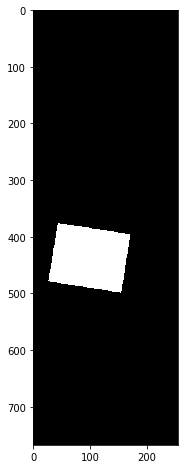

In [62]:
fp_mask = sol.vector.mask.footprint_mask(df=os.path.join('data/bv_test/bv_test_mask.geojson'),
                                      reference_im=img_url)
f, ax = plt.subplots(figsize=(8, 8))
_ = plt.imshow(fp_mask, cmap='gray')

In [63]:
img_url

'https://s3-us-west-2.amazonaws.com/prod-betterview/masked/static/199574/4cqiOBRWzD.jpeg'

### ...these seem to match up fairly well (forgiving the data quality issues with finer points of building footprints)


# So let's wrap up that up into a function and run it for all properties...

### Detail Functions:

In [101]:
def save_to_file(path, filename, geojson):
    with open(path + str(filename) + '.geojson', 'w') as file:
        file.write(json.dumps(geojson))
        
def create_geojson_files(df, path):
    df.apply(lambda x: save_to_file(path,
                                       x['property_id'], x['geojsons']), axis = 1)

### High Level Functions:

In [153]:
def create_masks_from_geojson(df, path):
    create_geojson_files(df, path)
    
    # Iterative approach work here
    for row in df.iterrows():
#         print('This is the row: {}'.format(row[1]))
        print()
        for footprint in row[1].geojsons:
            gdf = gpd.read_file(path + str(row[1].property_id) + '.geojson')
            print('This is the gdf: {}'.format(gdf))
            break
    # Pandas approach here
#     gpd_dfs = df.apply(lambda x: gpd.read_file(path + "/" + str(x['property_id']) + '.geojson'))
#     fp_mask = df.apply( lambda x:
#                 sol.vector.mask.footprint_mask(
#                     df=os.path.join(
#                         path + "/" + str(x['property_id']) + '.geojson'), reference_im=img_url))

In [154]:
path = '/Users/Tyler/betterview/solaris/solaris/data/bv_test/'
create_masks_from_geojson(new_df, path)

DriverError: '/Users/Tyler/betterview/solaris/solaris/data/bv_test/194289.geojson' not recognized as a supported file format.

In [111]:
gdf = gpd.read_file('data/bv_test/243094.geojson')

# Other attempt that stalled

In [15]:
df = pd.read_csv('data/cloudinary_urls.csv')
df.drop(columns = ['aspect_ratio', 'folder', 'resource_type'], inplace = True)

In [16]:
label_df = pd.read_csv('data/labeled_roof_material_zoom.csv')
label_df.drop(columns = ['width', 'height', 'megabytes', 'aspect_ratio', 'folder', 'upload_date', 'secure_url', 'image_format', 'resource_type', 'image', 'assignment', 'upload_status', 'status'], inplace = True)
label_df.sample(1)

,file_name,Material a = asphalt shingle t = clay tile mb = mod bit m = metal p = pvc/tpo e = epdm ra = rolled asphalt c = roof coating b = ballasted bur = built-up,Overhang,Damage s = severe m = minor n = none,Ponding,Rust s = severe m = minor n = none,Shape,Construction c = construction,Wear & tear n = none l = likely y = yes,Patching e = extensive m = moderate n = none,VA_ID,comments
555,Screen_Shot_2018-10-11_at_11.53.56_AM,a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VA557,NaN


In [17]:
# Save the material map for labels
material_map = {'a': 'asphalt shingle', 
                't': 'clay tile', 
                'mb': 'mod bit',  
                'm':'metal',
                'p': 'pvc/tpo', 
                'e': 'epdm', 
                'ra': 'rolled asphalt',  
                'c': 'roof coating', 
                'b': 'ballasted',  
                'bur': 'built-up'}

In [18]:
full_data = df.merge(label_df, left_on = 'file_name', right_on = 'VA_ID')

# Rename the column for material for sanity's sake
full_data.rename(columns = {'Material\na = asphalt shingle   t = clay tile\nmb = mod bit           m = metal\np = pvc/tpo               e = epdm\nra = rolled asphalt    c = roof coating \nb = ballasted            bur = built-up':
                           'material'}, inplace = True)

### Create Training CSV for Something other than Solaris

In [19]:
# Get the image urls and material labels from the full data set and rename them how Solaris wants
solaris_train_df = full_data[['secure_url', 'material']].rename(columns = {'secure_url': 'image', 'material':'label'})

# Remove all instances where a core material is present alongside other
solaris_train_df = solaris_train_df[~solaris_train_df['label'].str.contains('-[mat]', regex = True)]
solaris_train_df = solaris_train_df[~solaris_train_df['label'].str.contains('[mat]-', regex = True)]
solaris_train_df = solaris_train_df[~solaris_train_df['label'].str.match('u')]

# Map labels to meaningful names, with all materials outside of core 3 going into "other"
solaris_train_df['label'][solaris_train_df.label == 'm'] = 'metal'
solaris_train_df['label'][solaris_train_df.label == 'a'] = 'asphalt_shingle'
solaris_train_df['label'][solaris_train_df.label == 't'] = 'clay_tile'
mask = solaris_train_df.label.str.contains('metal|asphalt_shingle|clay_tile', regex = True)
solaris_train_df['label'][~mask] = 'other'

solaris_train_df.to_csv('data/material_train.csv')

### Try to get a prediction out of Solaris

In [20]:
import solaris as sol

In [21]:
config = sol.utils.config.parse('nets/configs/xdxd_spacenet4.yml')
inferer = sol.nets.infer.Inferer(config)
inference_data = sol.nets.infer.get_infer_df(config)
inferer(inference_data)

FileNotFoundError: [Errno 2] File b'/path/to/test_df.csv' does not exist: b'/path/to/test_df.csv'

# Something totally different

In [34]:
df = pd.read_csv('/Users/Tyler/Downloads/material_labeling_dturk.tsv', 
                 delimiter = '\t').drop(columns=['img_url', 'bv_detection', 'footprint_data', 'Summary', 'count'])

In [48]:
df[df.tyler_tag == 'asphalt_shingle'].drop(columns='tyler_tag').set_index('property_id').to_csv('/USERS/Tyler/Downloads/asphalt_shingle.txt')
df[df.tyler_tag == 'metal'].drop(columns='tyler_tag').set_index('property_id').to_csv('/USERS/Tyler/Downloads/metal_panel.txt')
df[df.tyler_tag == 'clay'].drop(columns='tyler_tag').set_index('property_id').to_csv('/USERS/Tyler/Downloads/clay_tile.txt')